**CNN (Convolution Neural Network)**


1. MNIST





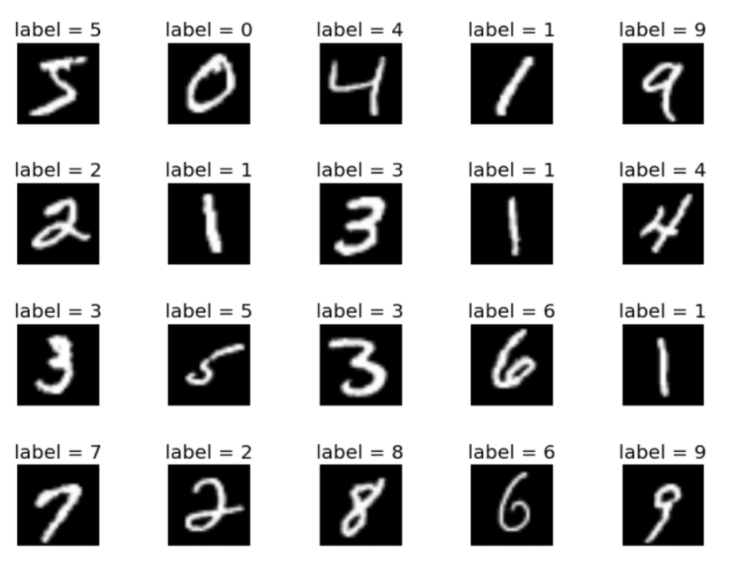

1.1 Define Hyper-parameters

In [27]:
import torch

In [28]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}") # 여기서 'cuda' 가 나와야 GPU를 사용하여 연산을 할 수 있습니다.

# Adjust Model Structure Depends on the Data
num_classes = 10 # label 0~9: total 10 classes
in_channel = 1 # black and white images: 1 channel (RGB: 3 channels)

# Hyper-parameters
batch_size = 10 # GPU 의 메모리가 클수록, 개별 data size 가 작을 수록 높게 설정 가능.
max_pool_kernel = 2 # pooling layer
learning_rate = 0.0001
num_epochs = 3

device: cuda


1.2 Load Data

In [29]:
import torchvision # 해당 Library 를 통해 vision 과 관련된 각종 built-in 함수를 사용하거나 dataset 등을 다운로드 할 수 있습니다.
import torchvision.transforms as transforms # MNIST "images" 를 "tensor" 로 변환해 model 이 처리할 수 있는 형태로 변환합니다.

In [30]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True) # MINIST training set 을 다운로드 합니다.
test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor()) # MNIST test set 을 다운로드 합니다.

In [31]:
len(train_data), len(test_data) # 각 set의 규모

(60000, 10000)

In [32]:
train_data[0][0].shape, train_data[0][1] # set 내부 특정 element 의 형태나 값를 보여줍니다.
# 첫번째는 data 의 size, 두번째는 해당 data 의 label 을 보여줍니다.
# 이러한 data 의 구성방식은 dataset 마다 다르므로 주의가 필요합니다.

(torch.Size([1, 28, 28]), 5)


check images

In [33]:
import matplotlib.pyplot as plt # 시각화 관련 라이브러리

In [34]:
print(f"Total train data: {len(train_data)}")
print(f"Total test data: {len(test_data)}")
print("*"*20)
print("Check data shape")
print("Data shape:",test_data[0][0].shape)
print("Data label:",test_data[0][1])

Total train data: 60000
Total test data: 10000
********************
Check data shape
Data shape: torch.Size([1, 28, 28])
Data label: 7


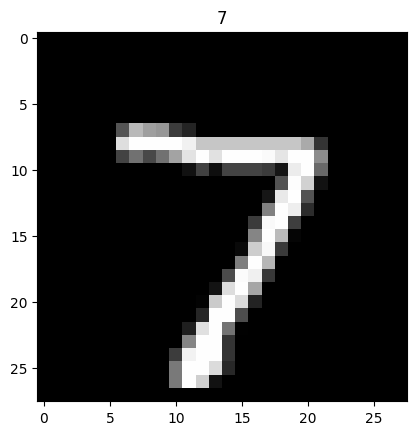

data shape: torch.Size([1, 28, 28])


In [35]:
plt.imshow(test_data[0][0].reshape(28,28), cmap='gray') # data[m][n] 에서 m ∈ {(data size)} (data)
plt.title(test_data[0][1]) # data[m][n] 에서 n ∈ {0, 1} (실제 data array / label)
plt.show()
print("data shape:",test_data[0][0].shape)

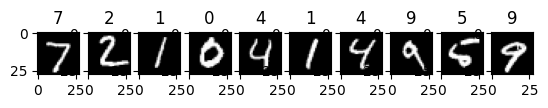

In [36]:
for i in range(10): # element N개를 보여줍니다.
  plt.subplot(1,10,i+1)
  plt.imshow(test_data[i][0].reshape(28,28), cmap='gray')
  plt.title(test_data[i][1])

In [37]:
# Data pixels. 각 pixel 의 값을 보여줍니다. 값이 1에 가까울 수록 흰색
test_data[0][0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000


1.3 Define Dataloader

In [38]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=True)
# 각 data를 dataloader 로 감싸 model 입력에 적절한 형태로 변경합니다.


1.4 Define Model

In [39]:
import torch.nn as nn # Neural Network 관련 Library
import torch.nn.functional as F # 일부 많이 쓰이는 라이브러리는 이와 같이 약자로 줄여서 간편하게 사용할 수 있습니다.
import torchsummary as summary # 무조건적으로 필요한 Library 는 아니지만 설계한 model 의 summary 를 볼 수 있습니다.

In [40]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet, self).__init__()
    # Configure layer1 & layer2 & 2 fc layers (dense layer)
    # 1x28x28

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channel, 16, 5, stride=1, padding=2), # 16x28x28
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel) # 16x14x14
    ) # Input 을 16*28*28, MaxPool layer 를 통과한 후 16*14*14 의 size 가 되도록 설정합니다. (stride = 1, padding = 2, function = ReLU)
    # Conv2d > BatchNorm > ReLU > MaxPool 의 순으로 layer 를 구성합니다.

    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, 5, stride=1, padding=2), # 32x14x14
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel) # 32x7x7
    )
    # Input 을 32*14*14, MaxPool layer 를 통과한 후 32*7*7 의 size 가 되도록 설정합니다. (stride = 1, padding = 2, function = ReLU)
    # Conv2d > BatchNorm > ReLU > MaxPool 의 순으로 layer 를 구성합니다.

    self.fc1 = nn.Linear(32*7*7, 120) # Input 을 32*7*7, output 을 120 으로 설정합니다.
    self.fc2 = nn.Linear(120, 10) # Input 을 120, output 을 10 (MNIST label 수) 로 설정합니다.

  def forward(self, x):
    # Execute layer1 & layer2 & fc layer (dense layer)
    x = self.layer1(x)
    x = self.layer2(x)

    x = x.reshape(x.size(0), -1) # (batch_size, 32*7*7=1568)

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.softmax(x, dim=1) # 각 label 의 예측결과를 softmax 함수를 통해 확률로 변환합니다.

    return x

In [41]:
model = ConvNet(num_classes).to(device) # 설계한 model 을 지정한 device 에 load 합니다. 이 때 훈련을 포함한 model 연산은 해당 device 내에서 이루어집니다.

In [42]:
#for i, (images, labels) in enumerate(train_loader):
#  if i==0:
#    images = images.to(device)
#    outputs = model(images)
#  else:
#    break

In [43]:
# cf) see network form
print(model)

# check parameter nums of model
params = 0
cnn_params = 0
fc_params = 0
for name, param in model.named_parameters():
  params += param.numel()
  if 'fc' not in name:
    cnn_params += param.numel()
  else:
    fc_params += param.numel()

# cf) check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
  print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))
print(f'total CNN parameters : {cnn_params}')
print(f'total FC parameters : {fc_params}')
print(f'total model parameters : {params}')
print('{:=^60}'.format("="))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
                       model summary                        
layer1.0.weight                  torch.Size([16, 1, 5, 5])   
layer1.0.bias                         torch.Size([16])       
layer1.1.weight                       torch.Size([16])       
layer1.1.bias                      

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

1.5 Train / Test

In [45]:
num_epochs = 3

In [46]:
total_step = len(train_loader)
loss_list = []

# Train
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader): #  images [Batch_size,1,28,28] labels [Batch_size,10]
    # model 과 동일한 위치에 data를 보냅니다. 이 위치가 다를 경우 model 훈련 등의 연산이 불가능합니다.
    images = images.to(device)
    labels = labels.to(device)

    # Forward Propagation
    outputs = model(images) #[Batch_size. 10]

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss.detach().cpu().numpy())

    # Print Loss for Tracking Training
    if (i+1) % 2000 == 0:
      acc = 0
      test_image, test_label = next(iter(test_loader))
      _, test_predicted = torch.max(model(test_image.to(device)).data, 1)

      for (pred, ans) in zip(test_predicted, test_label):
        if pred == ans:
          acc += 1
      acc = acc / len(test_predicted)

      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.1f}%'.format(epoch+1,num_epochs, i+1, total_step, loss.item(), acc*100))
      print('Testing data: [Predicted: {} / Real: {}]'.format(test_predicted, test_label))

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'model.pth')
    torch.load("model.pth")
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

Epoch [1/3], Step [2000/6000], Loss: 1.5840, Accuracy: 90.0%
Testing data: [Predicted: tensor([7, 2, 0, 1, 1, 0, 1, 8, 6, 4], device='cuda:0') / Real: tensor([7, 2, 0, 1, 9, 0, 1, 8, 6, 4])]
Epoch [1/3], Step [4000/6000], Loss: 1.4623, Accuracy: 100.0%
Testing data: [Predicted: tensor([2, 1, 4, 1, 8, 3, 7, 1, 8, 2], device='cuda:0') / Real: tensor([2, 1, 4, 1, 8, 3, 7, 1, 8, 2])]
Epoch [1/3], Step [6000/6000], Loss: 1.5499, Accuracy: 100.0%
Testing data: [Predicted: tensor([1, 9, 0, 3, 4, 9, 7, 3, 0, 1], device='cuda:0') / Real: tensor([1, 9, 0, 3, 4, 9, 7, 3, 0, 1])]
Epoch [2/3], Step [2000/6000], Loss: 1.4613, Accuracy: 100.0%
Testing data: [Predicted: tensor([4, 2, 2, 4, 2, 8, 5, 7, 6, 4], device='cuda:0') / Real: tensor([4, 2, 2, 4, 2, 8, 5, 7, 6, 4])]
Epoch [2/3], Step [4000/6000], Loss: 1.4764, Accuracy: 100.0%
Testing data: [Predicted: tensor([4, 3, 1, 0, 6, 9, 6, 6, 0, 6], device='cuda:0') / Real: tensor([4, 3, 1, 0, 6, 9, 6, 6, 0, 6])]
Epoch [2/3], Step [6000/6000], Loss: 1.46

In [47]:
# model 훈련 이후 Test를 실시해 Accuracy 를 측정합니다.
model.eval() # evaluation mode 를 사용해 model의 추가적인 학습 없이 test 를 실시합니다. (instead of mini-batch mean/var, batchnorm is used)
with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(test_loader)*batch_size, 100*correct/total))

Accuracy of the network on the 10000 test images 98.69%


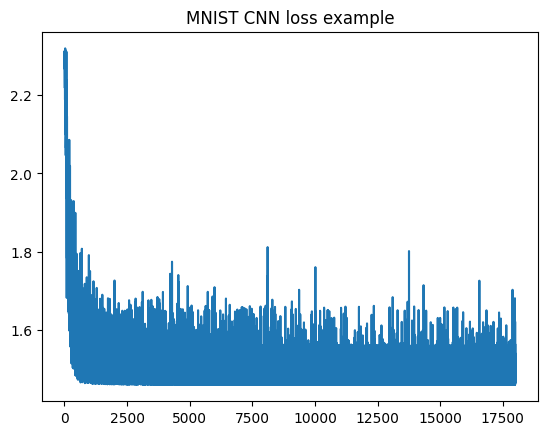

In [49]:
plt.plot(loss_list)
plt.title("MNIST CNN loss example")
plt.show()